In [145]:
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
import galsim
from dataset import get_COSMOS_Galaxy, get_LSST_PSF

%matplotlib inline

In [146]:
COSMOS_dir = '/mnt/WD6TB/tianaoli/COSMOS_23.5_training_sample/'
real_galaxy_catalog = galsim.RealGalaxyCatalog(dir=COSMOS_dir, sample=str(23.5))

fov_pixels = 48
pixel_scale = 0.2
gal_max_shear = 0.5
seeing = 0.7
atmos_max_shear = 0.2

In [147]:
rng = galsim.UniformDeviate(seed=19) # Initialize the random number generator
rng_gaussian = galsim.GaussianDeviate(seed=34, mean=seeing, sigma=0.18)
# PSF parameters
atmos_fwhm = 0.7 # arcsec (mean 0.7 for LSST)
# while atmos_fwhm < 0.35 or atmos_fwhm > 1.1: # sample fwhm
#     atmos_fwhm = rng_gaussian()
# atmos_e = rng() * atmos_max_shear # ellipticity of atmospheric PSF
atmos_e = 0.6 * atmos_max_shear
# atmos_beta = 2. * np.pi * rng()     # radians
atmos_beta = 2. * np.pi * 0.5     # radians
atmos_shear = galsim.Shear(e=atmos_e, beta=atmos_beta * galsim.radians)
opt_defocus = 0.3 + 0.4 * rng()     # wavelengths
opt_a1 = 2*0.5*(rng() - 0.5)        # wavelengths (-0.29)
opt_a2 = 2*0.5*(rng() - 0.5)        # wavelengths (0.12)
opt_c1 = 2*1.*(rng() - 0.5)         # wavelengths (0.64)
opt_c2 = 2*1.*(rng() - 0.5)         # wavelengths (-0.33)
opt_obscuration = 0.165             # linear scale size of secondary mirror obscuration $(3.4/8.36)^2$
lam = 700                           # nm    NB: don't use lambda - that's a reserved word.
tel_diam = 8.36 # telescope diameter / meters (8.36 for LSST, 6.5 for JWST)
pixel_scale = pixel_scale

psf = get_LSST_PSF(lam, tel_diam, opt_defocus, opt_c1, opt_c2, opt_a1, opt_a2, opt_obscuration,
                    atmos_fwhm, atmos_e, atmos_beta, 0, 0,
                    fov_pixels, pixel_scale=pixel_scale) 
psf_delta = np.zeros([fov_pixels, fov_pixels])
psf_delta[int(fov_pixels/2)-1,int(fov_pixels/2)-1] = 1

In [148]:
idx = 245 # index pf galaxy in the catalog

# Galaxy parameters 
gal_e = rng() * gal_max_shear       # shear of galaxy
gal_beta = 2. * np.pi * rng()       # radians
gal_shear = galsim.Shear(e=gal_e, beta=gal_beta*galsim.radians)
gal_mu = 1 + rng() * 0.1            # mu = ((1-kappa)^2 - g1^2 - g2^2)^-1 (1.082)
theta = 2. * np.pi * rng()          # radians
sky_level = 1.e3                     # ADU / arcsec^2
dx, dy = rng() - 0.5, rng() - 0.5

snr_list = [100, 50, 20, 10]
# gal_flux_list = [6.25e4, 2.5e4, 1e4, 0.75e4, 0.4e4]
gal_flux_list = []
gt_list = []
for snr in snr_list:  
    gal_flux = (snr**2) * (1 + np.sqrt(1 + 8*sky_level*(fov_pixels**2)*(pixel_scale**2)/(snr**2)))/2
    gal_flux_list.append(gal_flux)
    gt, gal_orig = get_COSMOS_Galaxy(catalog=real_galaxy_catalog, idx=idx, 
                                     gal_flux=gal_flux, sky_level=sky_level, 
                                     gal_e=gal_e, gal_beta=gal_beta, 
                                     theta=theta, gal_mu=gal_mu, dx=dx, dy=dy, 
                                     fov_pixels=fov_pixels, pixel_scale=pixel_scale)
    gt_list.append(gt)
    print('gal_flux={:.1f} \tSNR={:.1f}'.format(gal_flux, snr))

gal_flux=48222.7 	SNR=100.0
gal_flux=22752.6 	SNR=50.0
gal_flux=8788.8 	SNR=20.0
gal_flux=4343.5 	SNR=10.0


In [149]:
obs_list, obs_ori_list = [], []
for gt in gt_list:
    # Convolution via FFT
    conv = ifftshift(ifft2(fft2(psf) * fft2(gt))).real
    conv = torch.max(torch.zeros_like(conv), conv) # set negative pixels to zero

    # Add CCD noise (Poisson + Gaussian)
    obs = torch.poisson(conv) + torch.normal(mean=torch.zeros_like(conv), std=2*torch.ones_like(conv))
    obs_ori = torch.max(torch.zeros_like(obs), obs) # set negative pixels to zero
    # obs = (obs_ori - obs_ori.min())/(obs_ori.max() - obs_ori.min())

    obs_list.append(obs.numpy())
    obs_ori_list.append(obs_ori)

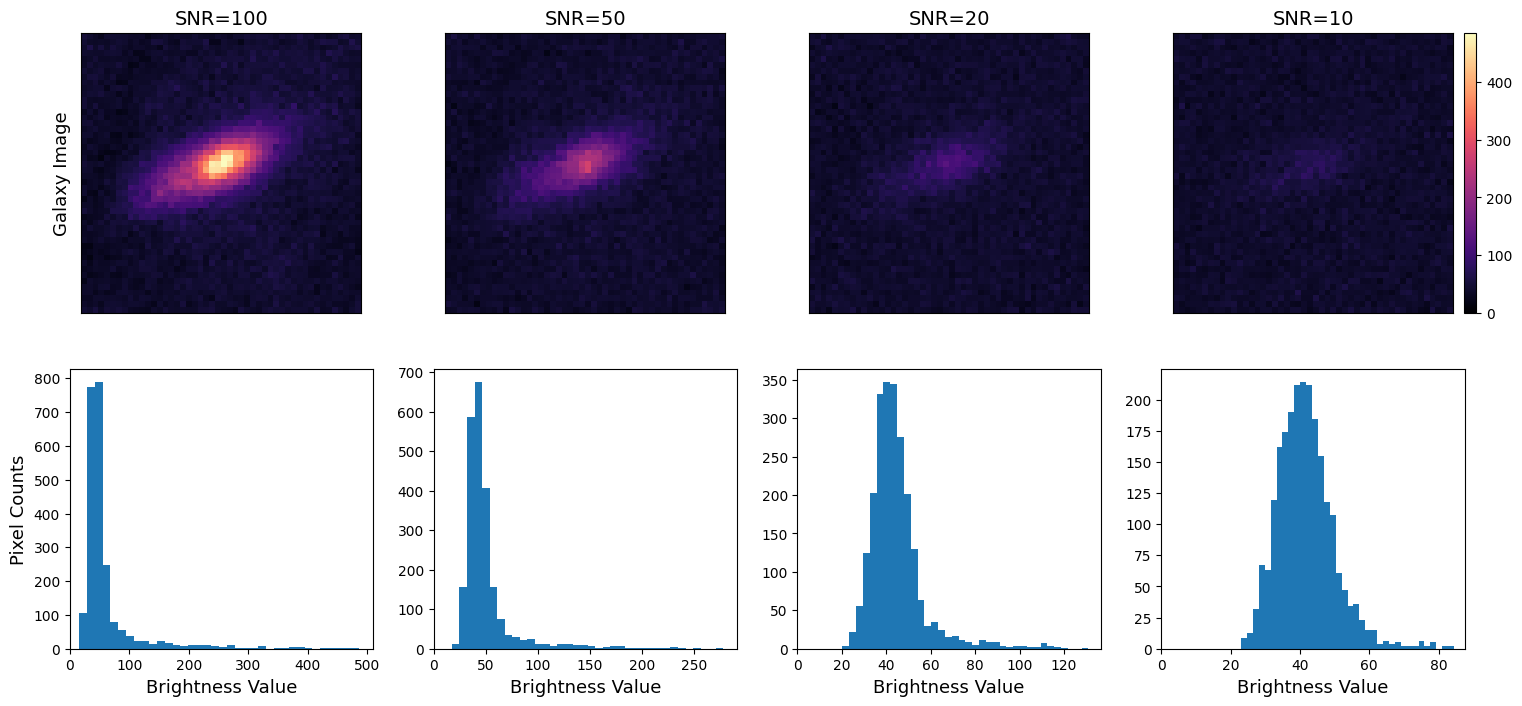

In [150]:
fig = plt.figure(figsize=(18,8))

vmax = np.max([obs.max() for obs in obs_list])
norm = matplotlib.colors.Normalize(vmax=vmax, vmin=0)

for idx, (snr, obs) in enumerate(zip(snr_list, obs_list)):

    ax = plt.subplot(2,4,idx+1)
    plt.imshow(obs, cmap='magma', norm=norm)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(f'SNR={snr}', fontsize=14)
    if idx == 0:
        plt.ylabel(f'Galaxy Image', fontsize=13)
    elif idx == 3:
        cax = fig.add_axes([ax.get_position().x1+6e-3, ax.get_position().y0, 7e-3, ax.get_position().height])
        plt.colorbar(cax=cax)
    
    plt.subplot(2,4,idx+5)
    plt.hist(obs.ravel(), bins=36)
    plt.xlim(0,)
    plt.xlabel('Brightness Value', fontsize=13)
    if idx == 0:
        plt.ylabel(f'Pixel Counts', fontsize=13)